# Imports

In [1]:
%matplotlib inline
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import datetime
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML

In [16]:
# configurações para os gráficos
sns.set_theme()
plt.rcParams['figure.figsize'] = [20, 12]

In [2]:
def jupyter_settings():
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container{width:90% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set_theme()

jupyter_settings()

## Loading data

In [135]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('datasets/store.csv', low_memory=False)

In [136]:
df_sales_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [137]:
df_store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [138]:
# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 Descrição dos Dados


In [139]:
df1 = df_raw.copy()

## 1.1 Rename Columns


In [140]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

cols_new = []

for c in cols_old:
    cols_new.append(inflection.underscore(c))
    
df1.columns = cols_new

## 1.2 Data Dimension

In [141]:
print(f'Número de Linhas: {df1.shape[0]}')
print(f'Número de Colunas: {df1.shape[1]}')

Número de Linhas: 1017209
Número de Colunas: 18


## 1.3 Data Types

In [142]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [143]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA

In [144]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [145]:
# competition_distance
# as distância que não existem vamos colocar 200000, que é um valor muito maior que a maior distância
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if np.isnan(x) else x)

# competition_open_since_month    
# vamos completar os Na's com o mês da coluna 'date'
df1['competition_open_since_month'] = df1[['date','competition_open_since_month']].apply(lambda x: x['date'].month
                                                                                        if np.isnan(x['competition_open_since_month'])
                                                                                        else x['competition_open_since_month'], axis=1)

# competition_open_since_year   
# vamos completar os Na's com o ano da coluna 'date'
df1['competition_open_since_year'] = df1[['date','competition_open_since_year']].apply(lambda x: x['date'].year
                                                                                        if np.isnan(x['competition_open_since_year'])
                                                                                        else x['competition_open_since_year'], axis=1)


# promo2_since_week      

df1['promo2_since_week'] = df1[['date','promo2_since_week']].apply(lambda x: x['date'].week
                                                                   if np.isnan(x['promo2_since_week'])
                                                                   else x['promo2_since_week'], axis=1)

# promo2_since_year   

df1['promo2_since_year'] = df1[['date','promo2_since_year']].apply(lambda x: x['date'].year
                                                                   if np.isnan(x['promo2_since_year'])
                                                                   else x['promo2_since_year'], axis=1)

# promo_interval  
df1['promo_interval'].fillna(0, inplace=True)

month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
df1['month_map'] = df1['date'].dt.month.map(month_map)


df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 
                                                                   else 1 if x['month_map'] in x['promo_interval'].split(',')
                                                                   else 0, axis=1)


## 1.6 Change Types

In [146]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [147]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(include=['object'])

### 1.7.1 Num Attributes

In [148]:
# Central Tendency
# média
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
# mediana
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion Tendency
dt1 = pd.DataFrame(num_attributes.apply(np.std)).T
dt2 = pd.DataFrame(num_attributes.apply(min)).T
dt3 = pd.DataFrame(num_attributes.apply(max)).T
dt4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
dt5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
dt6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

df_statistic = pd.concat([dt2, dt3, dt4, ct1, ct2, dt1, dt5, dt6]).T.reset_index()

In [149]:
# Renomeando as colunas
df_statistic.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [150]:
df_statistic

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [151]:
# sns.displot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [152]:
cat_attributes.apply(lambda x: len(x.unique()))

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

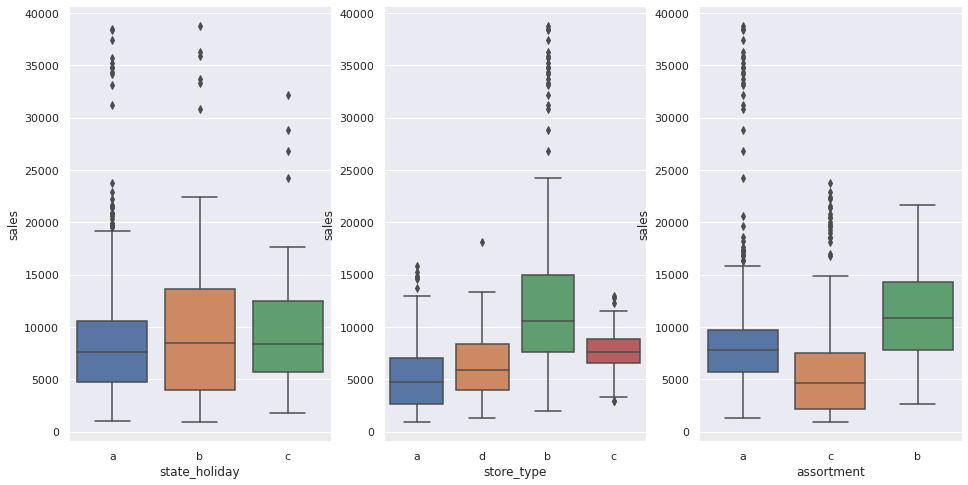

In [153]:
aux1 = df1[(df1['sales'] > 0) & (df1['state_holiday'] != '0')]

plt.subplot(1, 3, 1)
a1 = sns.boxplot(x='state_holiday', y='sales', data=aux1)
a1.figure.set_size_inches(16, 8)

plt.subplot(1, 3, 2)
a2 = sns.boxplot(x='store_type', y='sales', data=aux1)
a2.figure.set_size_inches(16, 8)

plt.subplot(1, 3, 3)
a3 = sns.boxplot(x='assortment', y='sales', data=aux1)
a3.figure.set_size_inches(16, 8)

In [154]:
df1.to_csv('datasets/data_train_store.csv', index=False)

# 2.0 Feature Engineering

In [155]:
df2 = pd.read_csv('datasets/data_train_store.csv', low_memory=False)

df2['date'] = pd.to_datetime(df2['date'])

## 2.1 Mapa Mental de Hipóteses

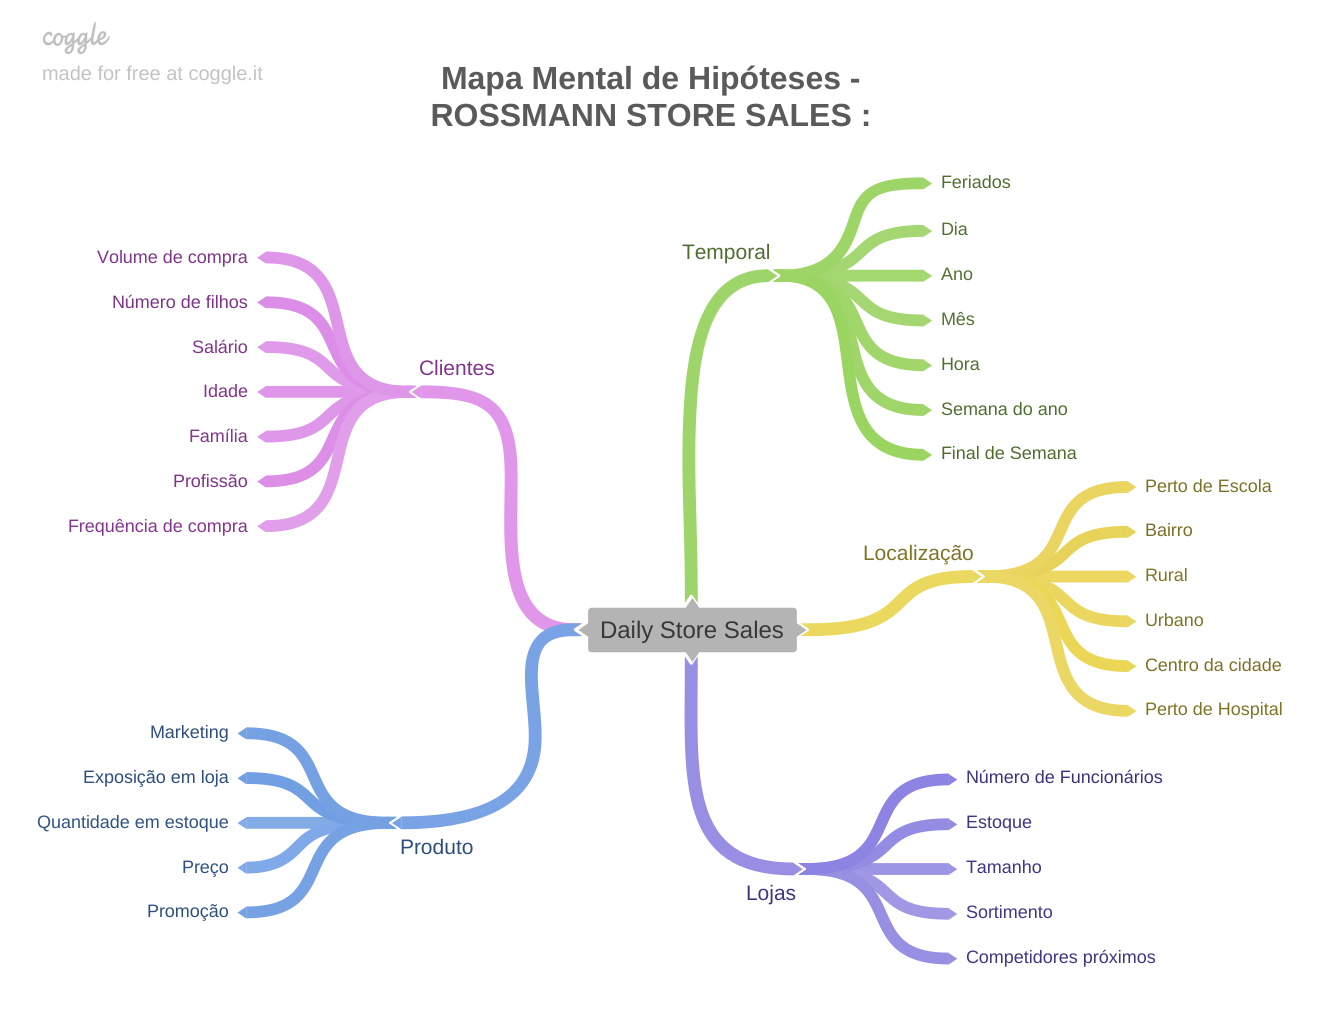

In [156]:
Image('img/mindmap_hypoteses.png')

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses de Lojas

**H1.** Lojas com número maior de funcionários deveriam vender mais.

**H2.** Lojas com maior capacidade de estoque deveriam vender mais.

**H3.** Lojas com maior porte deveriam vender mais.

**H4.** Lojas com maior sortimentos deveriam vender mais.

**H5.** Lojas com competidores mais próximos deveriam vender menos.

**H6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipóteses dos Produtos 

**H1.** Lojas que investem mais em Marketing deveriam vender mais

**H2.** Lojas com maior exposição de produto deveriam vender mais.

**H3.** Lojas com produtos com preço menor deveriam vender mais.

**H5.** Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.

**H6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**H7.** Lojas com mais dias de promoção deveriam vender mais.

**H8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Temporais

**H1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**H2.** Lojas deveriam vender mais ao longo dos anos.

**H3.** Lojas deveriam vender mais no segundo semestre do ano.

**H4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**H5.** Lojas deveriam vender menos aos finais de semana.

**H6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.2.4 Lista Final de Hipóteses 

Depois de pensar em várias hipóteses, vamos selecionar aquelas que podemos analisar com dados que já temos agora.

**H1.** Lojas com maior sortimentos deveriam vender mais.

**H2.** Lojas com competidores mais próximos deveriam vender menos.


**H3.** Lojas com competidores à mais tempo deveriam vendem mais.

**H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**H5.** Lojas com mais dias de promoção deveriam vender mais.

**H7.** Lojas com mais promoções consecutivas deveriam vender mais.

**H8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**H9.** Lojas deveriam vender mais ao longo dos anos.

**H10.** Lojas deveriam vender mais no segundo semestre do ano.

**H11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**H12.** Lojas deveriam vender menos aos finais de semana.

**H13.** Lojas deveriam vender menos durante os feriados escolares.


## 2.3 Feature Engineering

In [157]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
df2['week_of_year'] = df2['week_of_year'].astype('int64') 

# formato da data: Year-Week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                 month=x['competition_open_since_month'],
                                                                 day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).dt.days.astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) + '-1'
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).dt.days

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else
                                                      'extra' if x == 'b' else
                                                      'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 
                                                            'easter' if x == 'b' else
                                                            'christmas' if  x == 'c' else
                                                            'regular_day')

In [158]:
df2.to_csv('datasets/data_train_store2.csv', index=False)

# 3.0 Filtragem de Variáveis

In [2]:
df3 = pd.read_csv('datasets/data_train_store2.csv')

df3['date'] = pd.to_datetime(df3['date'])
df3['competition_since'] = pd.to_datetime(df3['competition_since'])
df3['promo_since'] = pd.to_datetime(df3['promo_since'])

## 3.1 Filtragem das Linhas

In [3]:
# Filtrar apenas as lojas abertas e que obtiveram vendas.
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [4]:
# Algumas colunas que não fazem mais sentido, ou que substituimos por outras.
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 Análise Exploratória dos Dados

In [5]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Variável Resposta

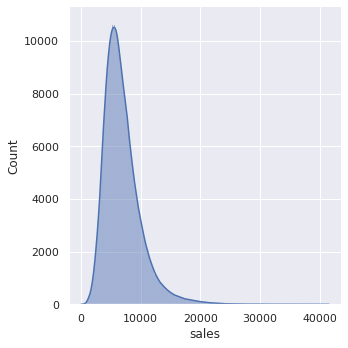

In [163]:
sns.displot(df4['sales'], kde=True);


### 4.1.2 Variável Num

In [164]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])

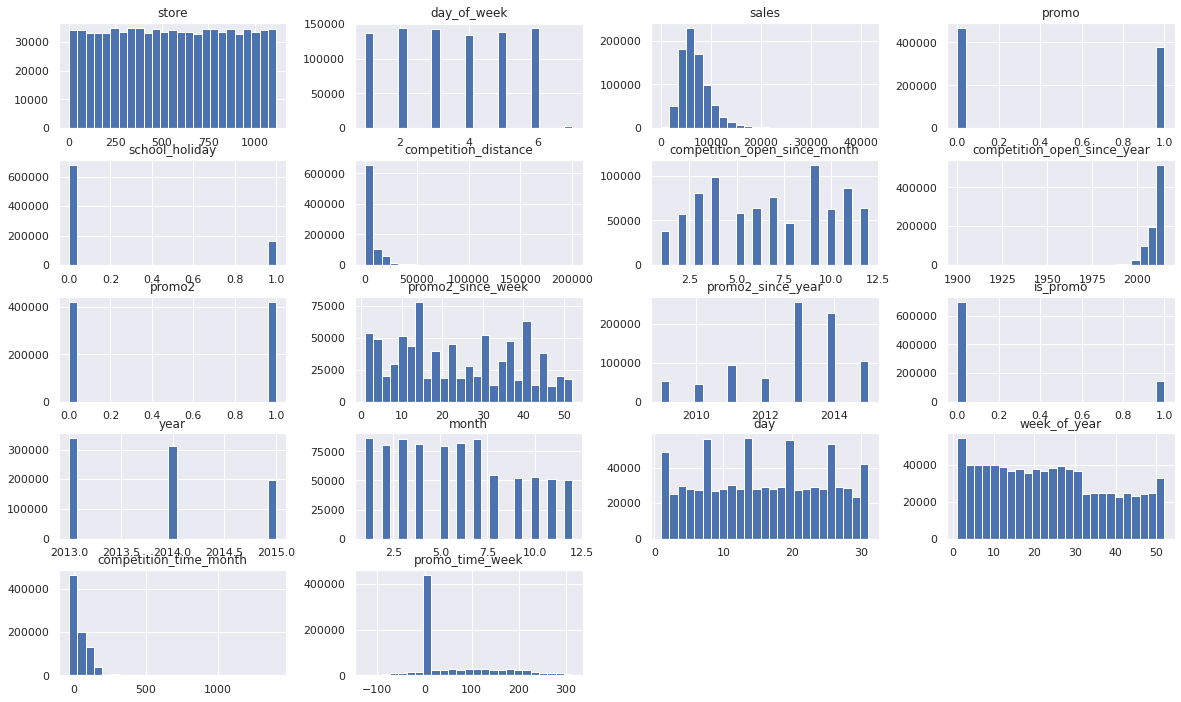

In [180]:
num_attributes.hist(bins=25);

### 4.1.3 Variáveis Categóricas

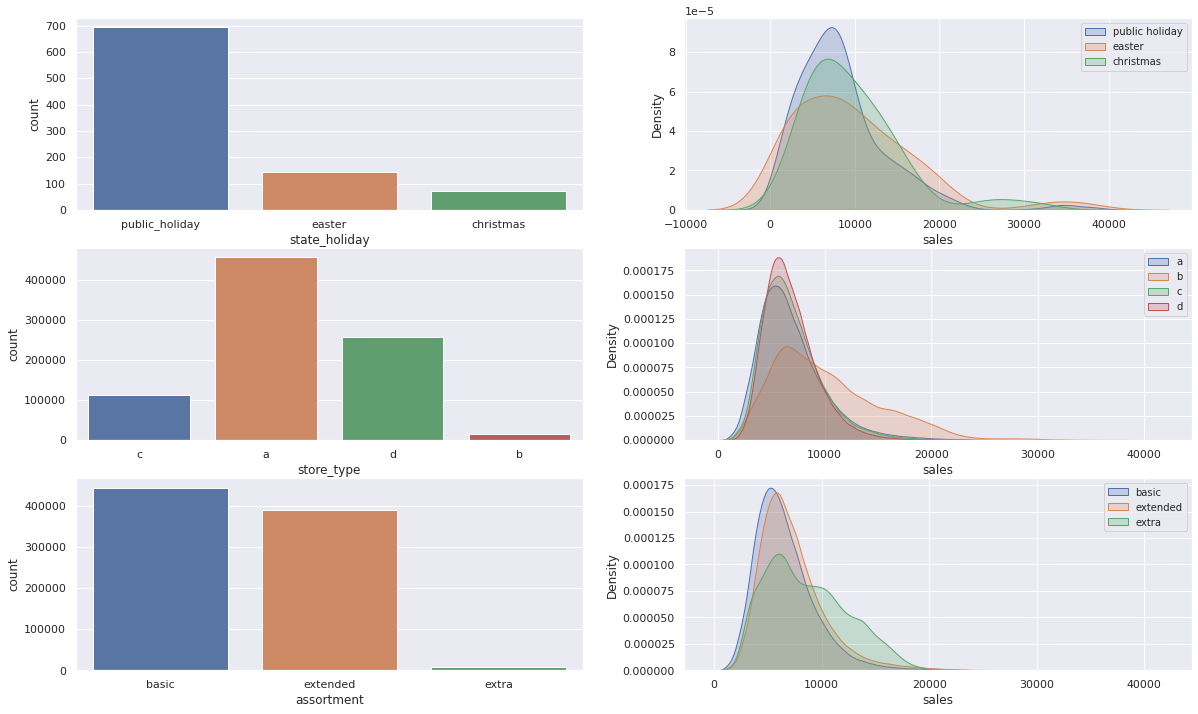

In [175]:
sns.set_theme()
plt.rcParams['figure.figsize'] = [20, 12]
# state holiday

plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']['state_holiday']
sns.countplot(x=a);

plt.subplot(3, 2, 2)
b = df4[df4['state_holiday'] == 'public_holiday']['sales']
sns.kdeplot(b, shade=True);


b = df4[df4['state_holiday'] == 'easter']['sales']
sns.kdeplot(b, shade=True);


b = df4[df4['state_holiday'] == 'christmas']['sales']
sns.kdeplot(b, shade=True);

plt.legend(labels=['public holiday', 'easter', 'christmas'], fontsize=10)
            
# store type
plt.subplot(3, 2, 3)
a = df4['store_type']
sns.countplot(x=a);

plt.subplot(3, 2, 4)
b = df4[df4['store_type'] == 'a']['sales']
sns.kdeplot(b, shade=True);

b = df4[df4['store_type'] == 'b']['sales']
sns.kdeplot(b, shade=True);

b = df4[df4['store_type'] == 'c']['sales']
sns.kdeplot(b, shade=True);

b = df4[df4['store_type'] == 'd']['sales']
sns.kdeplot(b, shade=True);

plt.legend(labels=['a', 'b', 'c', 'd'], fontsize=10)      


# assortment
plt.subplot(3, 2, 5)
a = df4['assortment']
sns.countplot(x=a);

plt.subplot(3, 2, 6)
b = df4[df4['assortment'] == 'basic']['sales']
sns.kdeplot(b, shade=True);

b = df4[df4['assortment'] == 'extended']['sales']
sns.kdeplot(b, shade=True);

b = df4[df4['assortment'] == 'extra']['sales']
sns.kdeplot(b, shade=True);

plt.legend(labels=['basic', 'extended', 'extra'], fontsize=10) 

## 4.2 Análise Bivariada

### 4.2.1 Análise das Hipóteses

#### 4.2.1.1 H1. Lojas com maior sortimentos deveriam vender mais.
**Falso.** Lojas com maior sortimento vendem menos.

<AxesSubplot:>

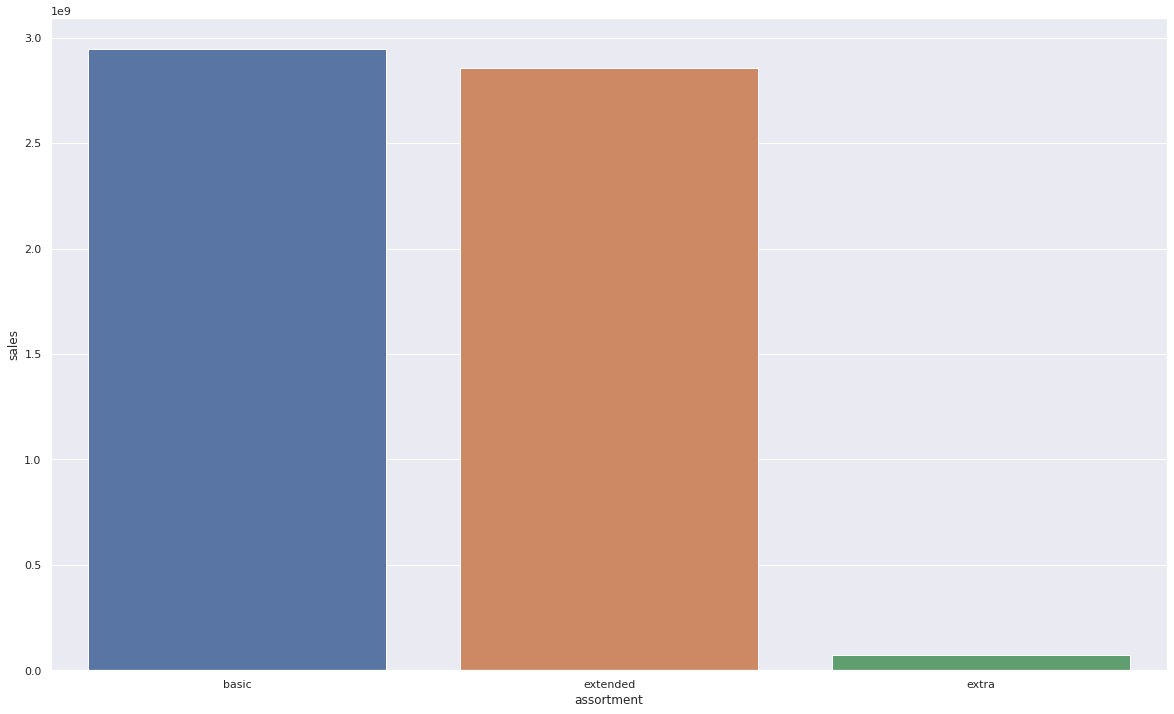

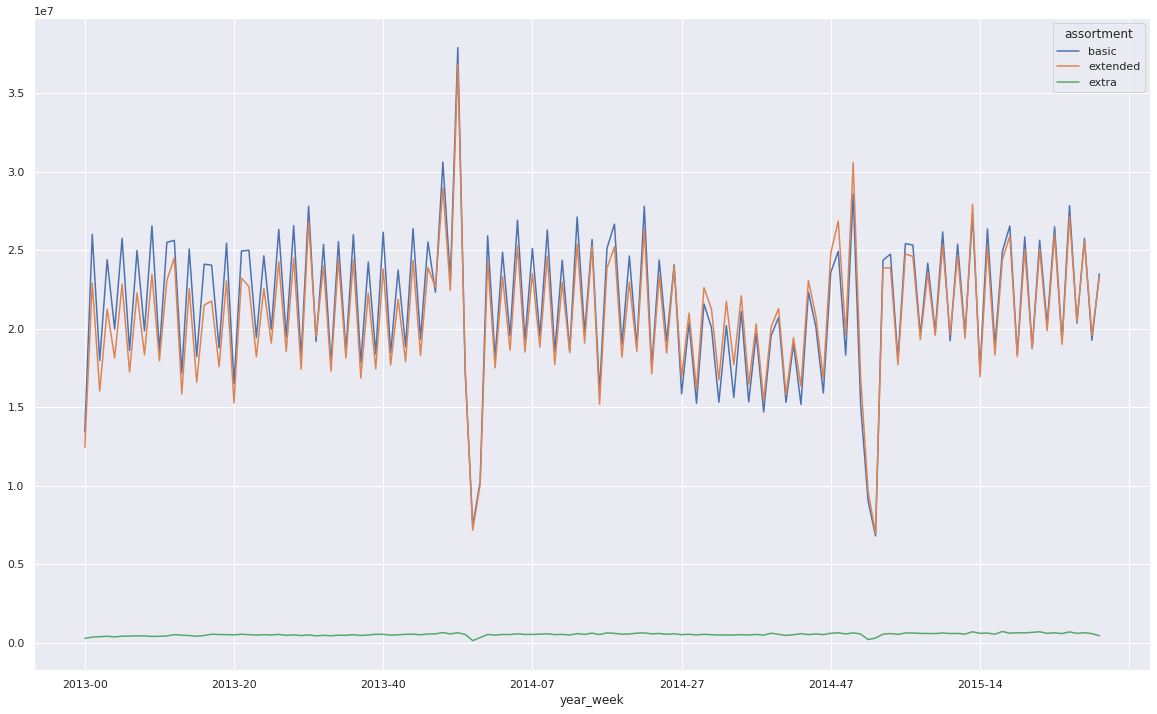

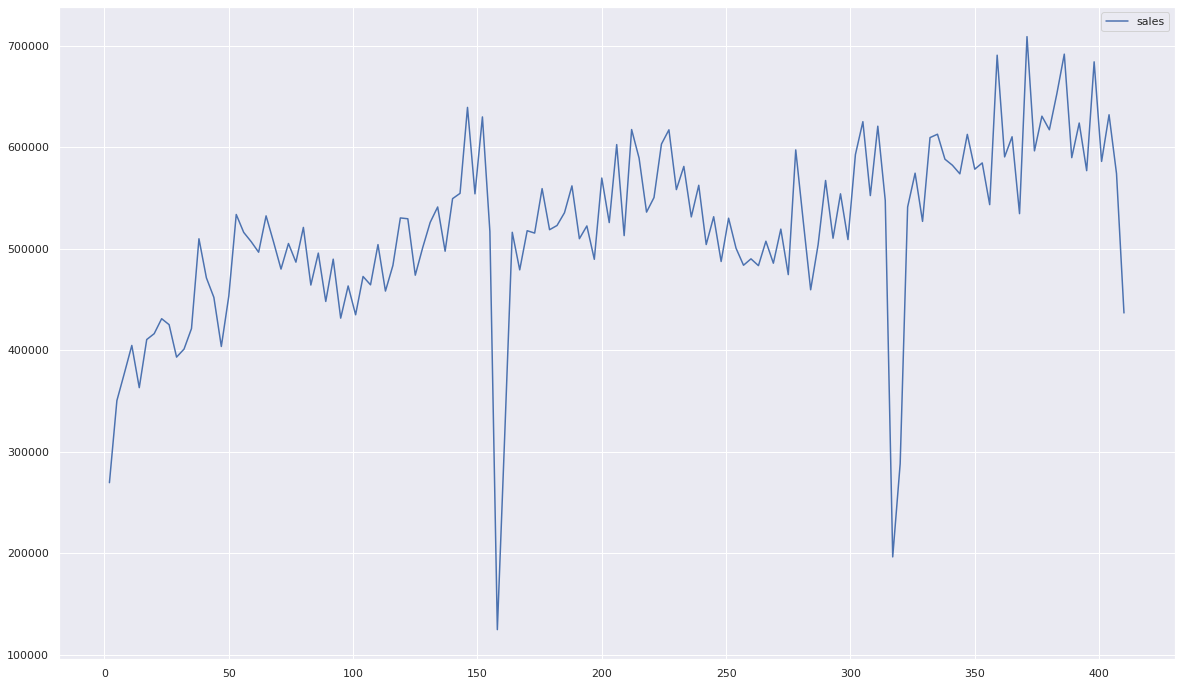

In [29]:
# assortment x sales
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux2[aux2['assortment'] == 'extra'].plot()

In [24]:
aux3.head()

assortment,year_week,basic,extended,extra
0,2013-00,13434262,12425669,269404
1,2013-01,26007250,22917693,350279
2,2013-02,17970974,16029584,377207
3,2013-03,24392076,21243431,404662
4,2013-04,19972891,18130077,363061


#### 4.2.1.2 H2. Lojas com competidores mais próximos deveriam vender menos.
**Falso.** Lojas com competidores mais próximos vendem mais.

<AxesSubplot:>

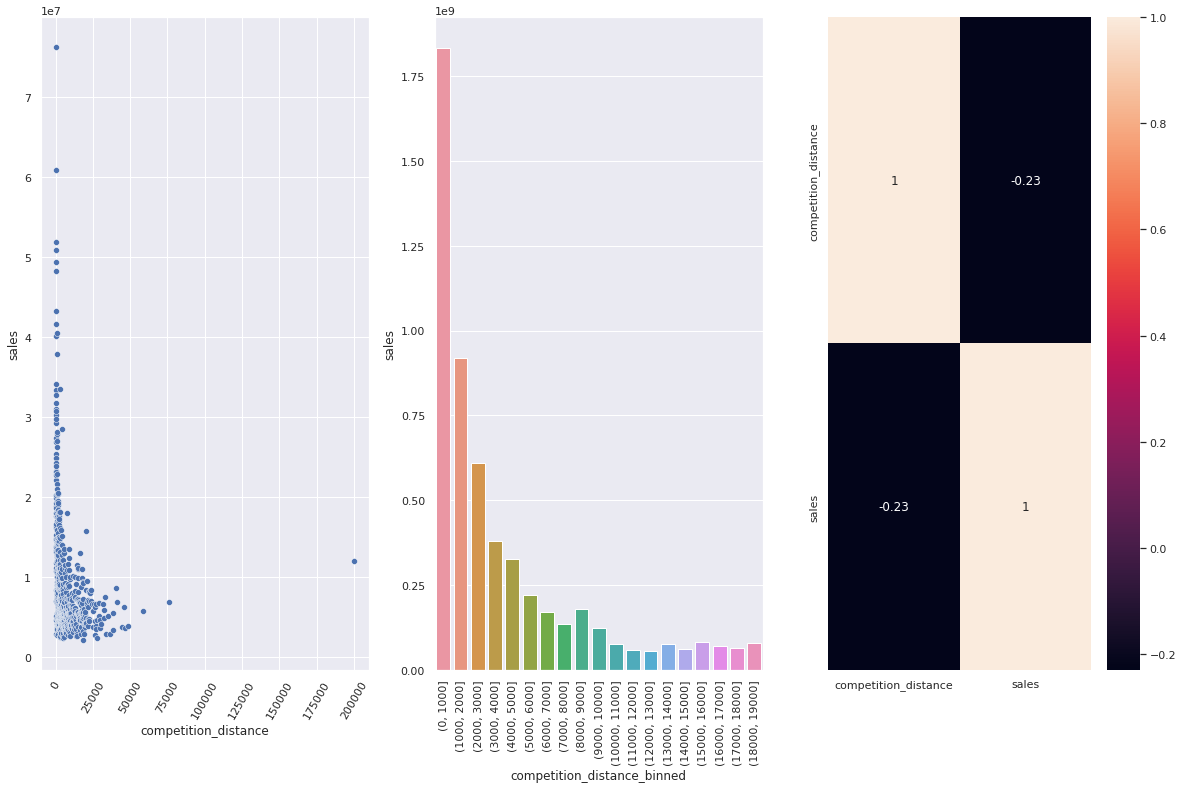

In [64]:
# competition_distance x sales
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(data=aux1, x='competition_distance', y='sales')
plt.xticks(rotation=60)

plt.subplot(1, 3, 2)
b = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=b)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(data=aux2, x='competition_distance_binned', y='sales')
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### 4.2.1.3 H3. Lojas com competidores à mais tempo deveriam vendem mais
**Falso.** Lojas com competidores à mais tempo vendem menos.

<AxesSubplot:>

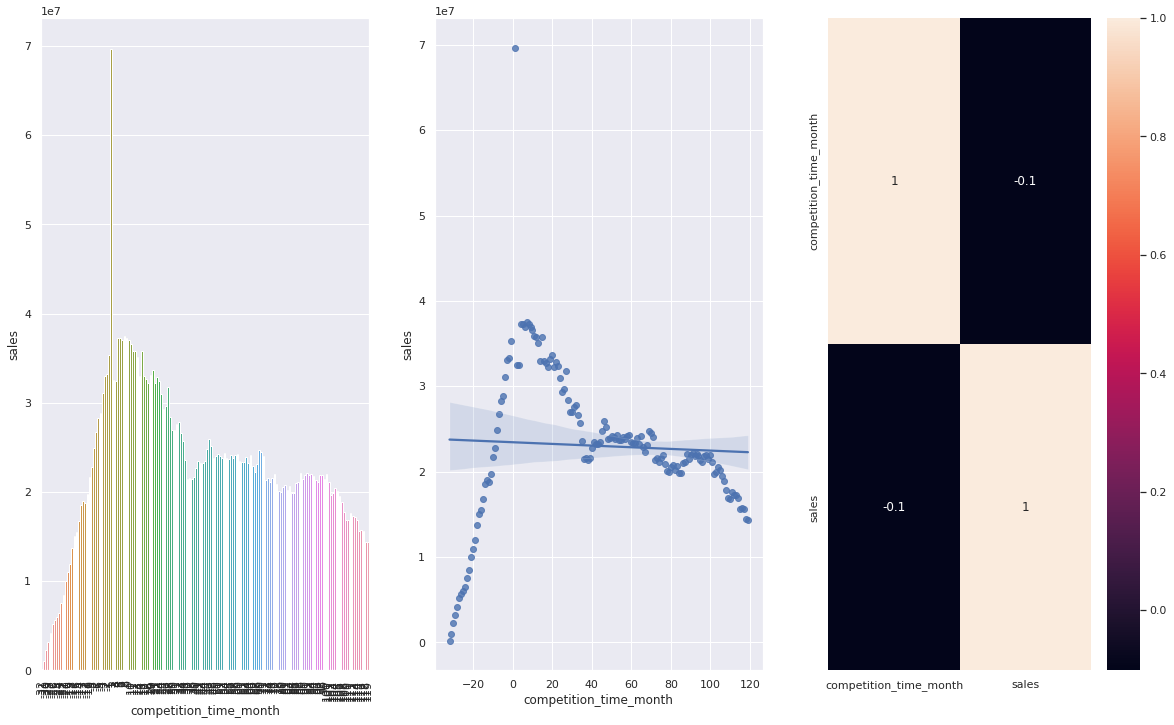

In [79]:
# competition_open_since_month x sales   
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

plt.subplot(1, 3, 1)
sns.barplot(data=aux2, x='competition_time_month', y='sales')
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(data=aux2, x='competition_time_month', y='sales')

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

## 4.3 Análise Multivariada